<a href="https://colab.research.google.com/github/gabrielsyj/Deep-Learning-Breast-Cancer-Detection/blob/main/FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CM3070 Final Project**

## **Final Report**

## by Soh Yi Jie Gabriel (220516695)

## **3.2 Project Idea 2: Deep Learning Breast Cancer Detection**

## **Introduction**

Breast cancer remains one of the most prevalent and life-threatening diseases worldwide, and early, accurate diagnosis through mammographic screening is critical for patient outcomes. However, current practice faces challenges such as radiologist fatigue, inter-observer variability, and limited availability of expert readers, which can reduce screening reliability. Artificial intelligence (AI) offers the potential to complement human expertise by providing reproducible, efficient, and accurate diagnostic support.

In accordance with Template 3.2: Deep Learning Breast Cancer Detection, this project explores the application of deep learning for automated breast cancer detection in mammography.  The complete system was created using Google Colab's open-source tools to guarantee accessibility and reproducibility.  Preprocessing procedures (grayscale normalization, binary label remapping, augmentation, and class balancing) are included in the pipeline, along with a series of models: a baseline CNN, MobileNet, and EfficientNet with transfer learning.  Because of their capacity to provide excellent diagnostic results at a low computational cost, these lightweight designs were selected for use in resource-constrained clinical settings.

The CBIS-DDSM dataset was used for testing and training in the evaluation process, while the INbreast dataset was used for additional validation to determine generalizability across populations.  Using common measures like accuracy, sensitivity, specificity, and ROC-AUC, performance was compared to radiologist accuracy (87–90%). The results were displayed in easy-to-read tables and visual aids including training loss plots, ROC curves, and confusion matrices.  The project incorporated explainability tools, Grad-CAM for spatial heatmaps and SHAP for feature-level explanations, to address transparency and trust. This allowed for a critical examination of the model's emphasis and reasoning.

The findings demonstrate that therapeutically relevant performance can be attained by lightweight CNN architectures while maintaining efficiency and reproducibility.  By utilising open-source implementation, interpretable AI techniques, and publicly accessible datasets, the initiative prioritises inclusivity and transparency over numerical accuracy.  When taken as a whole, these contributions show a viable path toward AI-assisted breast cancer screening that strikes a compromise between precision, effectiveness, and equity in practical healthcare implementation.

## **Accessing the Dataset via Google Drive**

We first link the notebook to Google Drive, which houses the CBIS-DDSM dataset, before we can start working with it in Google Colab.  Similar to dealing with local files, we mount the Drive using Colab's built-in google.colab.drive module, allowing its contents to be accessed straight from the Colab environment.  With this configuration, the CBIS_DDSM.zip file can be copied from Drive to the current working directory, where it can be unzipped and utilized for model training and preprocessing.  This step is crucial for effective data access, particularly when working with huge cloud-based medical imaging datasets.

In [72]:
# import the colab drive module to connect to google drive
from google.colab import drive

import os

In [73]:
# Mount your google drive so you can access the CBIS_DDSM.zip dataset stored there

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Preparing the Dataset for Use**

The necessary datasets are copied into a specific working directory in Colab for reliable access after mounting Google Drive.  To conserve storage space, the main dataset, CBIS-DDSM, is moved and extracted discreetly. Following extraction, the original zip file is deleted.  If possible, support for the INbreast dataset is also added to facilitate cross-dataset validation and enhance generalizability.  Both datasets are dependably accessible in further phases of preprocessing, training, and evaluation since they are kept in well-defined paths (cbis_path, inbreast_path).  Reproducibility, effective storage management, and adaptability for expanding the project to multiple datasets are guaranteed by this structured architecture.

In [74]:
# Define dataset locations in Drive
ddsm_zip_path = "/content/gdrive/My Drive/CBIS_DDSM.zip"
inbreast_zip_path = "/content/gdrive/My Drive/INbreast.zip"   # optional second dataset for cross-validation

# Create a working directory
os.makedirs("/content/data", exist_ok=True)

# --- Extract CBIS-DDSM ---
!cp "{ddsm_zip_path}" /content/data/
!unzip -qq /content/data/CBIS_DDSM.zip -d /content/data/
!rm /content/data/CBIS_DDSM.zip

# --- Extract INbreast (if available) ---
if os.path.exists(inbreast_zip_path):
    !cp "{inbreast_zip_path}" /content/data/
    !unzip -qq /content/data/INbreast.zip -d /content/data/
    !rm /content/data/INbreast.zip
    print("INbreast dataset extracted successfully.")

# Set dataset paths for later use
cbis_path = "/content/data/CBIS_DDSM"
inbreast_path = "/content/data/INbreast" if os.path.exists("/content/data/INbreast") else None

print("Datasets ready ✅")
print("CBIS-DDSM path:", cbis_path)
if inbreast_path:
    print("INbreast path:", inbreast_path)

replace /content/data/CBIS_DDSM/csv_description/calc_case_description_test_set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/data/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
INbreast dataset extracted successfully.
Datasets ready ✅
CBIS-DDSM path: /content/data/CBIS_DDSM


## **Importing Required Libraries**

To facilitate preprocessing, modeling, assessment, and interpretability, this project makes use of a wide range of libraries.  Matplotlib and Seaborn offer lucid visuals, while OS, Numpy, and Pandas manage data and files.  Scikit-learn provides metrics including confusion matrices, AUC, and ROC curves as well as dataset splitting.  TensorFlow/Keras powers the deep learning pipeline, which consists of layers, models, optimizers, callbacks, and ImageDataGenerator for real-time augmentation.  Transfer learning is made possible by pretrained architectures like as MobileNetV2 and EfficientNetB0, which guarantee effectiveness and high accuracy.  Grad-CAM and SHAP are used to provide a transparent explanation of model predictions.  When combined, these resources produce an AI system for breast cancer detection that is both clinically useful and reproducible.

In [75]:
# ================================
# 📦 Imports for Full Project Pipeline
# (data access, preprocessing, modeling, evaluation, explainability, reproducibility)
# ================================

# ---- Core / utilities
import os
import sys
import gc
import math
import json
import time
import random
import warnings
from pathlib import Path
from typing import Optional, Tuple, Dict, List

# ---- Numerics & tables
import numpy as np
import pandas as pd

# ---- Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Image I/O & processing
import cv2
from PIL import Image

# ---- Scikit-learn: splits & metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle as sk_shuffle
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

# ---- TensorFlow / Keras (DL core)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# ---- Pretrained architectures (Transfer Learning)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# ---- Explainability
import shap  # SHAP for feature-level attributions (model-agnostic / TF integration)

# ---- Progress & misc
from tqdm import tqdm

# ---- (Optional) Colab & Drive (only used when running in Colab)
try:
    from google.colab import drive  # mount Google Drive if in Colab
except Exception:
    pass

# ---- Silence noisy warnings by default (can be toggled)
warnings.filterwarnings("ignore")

# ---- Matplotlib defaults (cleaner plots)
sns.set(context="notebook", style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


## **Loading and Preparing Labels**

To enable supervised training, both CBIS-DDSM and INbreast required careful preprocessing of their label structures. For CBIS-DDSM, the original multi-class labels were simplified into a binary format, mapping benign findings (BI-RADS categories 1 and 3) to 0 and malignant findings (categories 2 and 4) to 1. Baseline patches were excluded by selecting only abnormal slices, ensuring that the model focused on diagnostically relevant regions. The mammogram tensors were reshaped into a consistent format of
(
𝐻
,
𝑊
,
1
)
(H,W,1) for grayscale input and normalized to the
[
0
,
1
]
[0,1] range to stabilize training. For INbreast, the raw DICOM images and metadata in the provided CSV were processed using pydicom and mapped to binary labels: benign (BI-RADS 1–3) versus malignant (BI-RADS 4a–6). After z-score normalization and resizing to
224
×
224
224×224, images were exported to a structured directory with class-balanced augmentation, enabling reproducible loading through Keras’ image_dataset_from_directory. This unified approach to label preparation ensured consistency across datasets, balanced class distributions, and reliable inputs for downstream CNN and transfer learning models.

In [76]:
# ==== Loading and Preparing Labels (CBIS-DDSM) ====
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --------------------
# Reproducibility
# --------------------
RANDOM_SEED = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# --------------------
# Paths
# --------------------
cbis_path = Path(cbis_path)  # uses your earlier variable
np_dir = cbis_path / "numpy data"

# --------------------
# Helpers
# --------------------
def remap_label(y):
    """
    Map CBIS-DDSM labels to binary:
      1,3 -> 0 (benign)
      2,4 -> 1 (malignant)
    """
    if y in (1, 3):
        return 0
    if y in (2, 4):
        return 1
    raise ValueError(f"Unexpected label value: {y}")

def prepare_images(X):
    """
    Ensure shape (N, H, W, 1) and scale to [0,1] float32.
    CBIS tensors are 16-bit grayscale.
    """
    # Add channel if missing
    if X.ndim == 3:
        X = X[..., np.newaxis]
    # Scale to [0,1] and convert to float32
    X = (X.astype(np.uint16) / 65535.0).astype(np.float32)
    return X

# --------------------
# Load raw abnormal-only slices
# (skip baseline patches via [1::2] to match your original pipeline)
# --------------------
train_X_raw = np.load(np_dir / "train_tensor.npy")[1::2]
train_y_raw = np.load(np_dir / "train_labels.npy")[1::2]

test_X_raw = np.load(np_dir / "public_test_tensor.npy")[1::2]
test_y_raw = np.load(np_dir / "public_test_labels.npy")[1::2]

# --------------------
# Remap labels to binary
# --------------------
train_y = np.array([remap_label(int(y)) for y in train_y_raw], dtype=np.int64)
test_y  = np.array([remap_label(int(y)) for y in test_y_raw],  dtype=np.int64)

# --------------------
# Prepare images (H,W,1) and normalize
# --------------------
train_X = prepare_images(train_X_raw)
test_X  = prepare_images(test_X_raw)

# --------------------
# Create an internal validation split (stratified) from the TRAIN set
# (You still retain the provided "public test" set separately)
# --------------------
X_train, X_val, y_train, y_val = train_test_split(
    train_X,
    train_y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_y,
)

# --------------------
# Quick sanity checks / small summary
# --------------------
def count_dict(y):
    u, c = np.unique(y, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

summary = pd.DataFrame({
    "split": ["train", "val", "public_test"],
    "N_samples": [len(X_train), len(X_val), len(test_X)],
    "class_counts": [count_dict(y_train), count_dict(y_val), count_dict(test_y)]
})

print(summary.to_string(index=False))

# Shapes for downstream code
print(
    f"\nShapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {test_X.shape}\n"
    f"           y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {test_y.shape}"
)


      split  N_samples      class_counts
      train       2140 {0: 1254, 1: 886}
        val        536  {0: 314, 1: 222}
public_test        336  {0: 219, 1: 117}

Shapes -> X_train: (2140, 150, 150, 1), X_val: (536, 150, 150, 1), X_test: (336, 150, 150, 1)
           y_train: (2140,), y_val: (536,), y_test: (336,)


In [77]:
# ===========
# Setup
# ===========
!pip -q install pydicom albumentations opencv-python

import os, re, cv2, pydicom, warnings, random
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import albumentations as A

warnings.filterwarnings("ignore")

# ---- Paths (edit if yours differ)
BASE = Path("/content/data")
CSV_PATH   = BASE / "INbreast Release 1.0" / "INbreast.csv"        # your CSV (semicolon-delimited)
DICOM_DIR  = BASE / "INbreast Release 1.0" / "AllDICOMs"           # raw DICOMs
OUT_ROOT   = BASE / "inbreast_png"                                 # will create benign/ malignant subfolders here

OUT_ORIG   = OUT_ROOT / "orig"                                     # (optional) stash of originals by class
OUT_AUG    = OUT_ROOT / "aug"                                      # (optional) stash of augs by class
CLASS_DIRS = {
    0: OUT_ROOT / "benign",        # final folder structure for tf loader
    1: OUT_ROOT / "malignant"
}

# Make directories
for p in [OUT_ROOT, OUT_ORIG, OUT_AUG, *CLASS_DIRS.values()]:
    p.mkdir(parents=True, exist_ok=True)

# ===========
# Helpers
# ===========
def birads_to_binary(x: str) -> int:
    """
    Map BI-RADS to binary: benign=0 (1,2,3) | malignant=1 (4a,4b,4c,5,6)
    """
    s = str(x).strip().lower()
    if s in {"1","2","3"}:
        return 0
    if s in {"4","4a","4b","4c","5","6"}:   # tolerate raw "4" if present
        return 1
    raise ValueError(f"Unexpected BI-RADS label: {x}")

def extract_number_from_filename(fname: str) -> str:
    """
    INbreast DICOMs are often like '205_1.dcm' -> '205'.
    This extracts the leading integer id.
    """
    m = re.match(r"(\d+)", fname)
    return m.group(1) if m else None

def zscore(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    return (img - img.mean()) / (img.std() + 1e-8)

def to_uint8(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # [0,1]
    return (img * 255.0).astype(np.uint8)

# Albumentations pipeline (reasonable defaults)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.Rotate(limit=20, p=0.5, border_mode=cv2.BORDER_REPLICATE),
    A.Affine(scale=(0.9, 1.1), rotate=(-10, 10), shear=(-5,5), p=0.5)
])

# ===========
# Read CSV + build DICOM index
# ===========
df = pd.read_csv(CSV_PATH, delimiter=";")
df.columns = df.columns.str.strip()

# Column names occasionally vary; try robust resolution
file_col_candidates = ["File Name", "FileName", "ImageID", "File"]
birads_col_candidates = ["Bi-Rads", "BI-RADS", "Birads", "BI-Rads", "BI_RADS"]

def resolve_col(cands):
    for c in cands:
        if c in df.columns:
            return c
    raise KeyError(f"None of {cands} found in CSV columns: {list(df.columns)}")

COL_FILE = resolve_col(file_col_candidates)
COL_BIR  = resolve_col(birads_col_candidates)

print(f"CSV rows: {len(df)}, using file col '{COL_FILE}', BI-RADS col '{COL_BIR}'")

# Map DICOM files by number
dicoms = [f for f in os.listdir(DICOM_DIR) if f.lower().endswith(".dcm")]
number_to_dicom = {}
for f in dicoms:
    num = extract_number_from_filename(f)
    if num is not None:
        number_to_dicom[num] = f

print(f"DICOMs indexed: {len(number_to_dicom)}")

# ===========
# Convert DICOMs -> PNGs under benign/malignant
# ===========
resize_hw = (224, 224)
n_augs_per_image = 2            # change as needed
records = []                    # for optional CSV export
skipped = 0

for idx, row in df.iterrows():
    file_num_raw = str(row[COL_FILE]).strip()
    # Some sheets store like 205.0 – normalize to int-like
    file_num = re.match(r"(\d+)", file_num_raw).group(1) if re.match(r"(\d+)", file_num_raw) else file_num_raw

    if file_num not in number_to_dicom:
        skipped += 1
        continue

    label_bin = birads_to_binary(str(row[COL_BIR]))

    dicom_path = DICOM_DIR / number_to_dicom[file_num]
    try:
        ds  = pydicom.dcmread(str(dicom_path))
        img = ds.pixel_array.astype(np.float32)

        # Normalize -> resize -> uint8
        img = zscore(img)
        img = cv2.resize(img, resize_hw, interpolation=cv2.INTER_AREA)
        img_u8 = to_uint8(img)

        # Save original into class folder
        cls_dir = CLASS_DIRS[label_bin]
        save_name = f"{file_num}_orig.png"
        save_path = cls_dir / save_name
        cv2.imwrite(str(save_path), img_u8)

        records.append({"image_path": str(save_path), "label_bin": label_bin})

        # Augment & save
        for i in range(n_augs_per_image):
            aug_img = augment(image=img_u8)["image"]
            aug_name = f"{file_num}_aug{i}.png"
            aug_path = cls_dir / aug_name
            cv2.imwrite(str(aug_path), aug_img)
            records.append({"image_path": str(aug_path), "label_bin": label_bin})

    except Exception as e:
        skipped += 1

print(f"Saved PNGs to {OUT_ROOT}. Skipped: {skipped}")

meta = pd.DataFrame(records)
print(meta["label_bin"].value_counts())

# ===========
# Optional: create train/val/test CSVs (stratified)
# (Directory loading in Keras doesn’t need these—but they’re handy for bookkeeping.)
# ===========
train_meta, test_meta = train_test_split(
    meta, test_size=0.15, random_state=42, stratify=meta["label_bin"]
)
train_meta, val_meta = train_test_split(
    train_meta, test_size=0.1765, random_state=42, stratify=train_meta["label_bin"]
)  # 0.1765 of 85% ≈ 15% => final split ~70/15/15

splits_dir = BASE / "splits"
splits_dir.mkdir(exist_ok=True, parents=True)
train_meta.to_csv(splits_dir / "inbreast_train.csv", index=False)
val_meta.to_csv(splits_dir / "inbreast_val.csv", index=False)
test_meta.to_csv(splits_dir / "inbreast_test.csv", index=False)

print("Split sizes ->",
      "train:", len(train_meta),
      "val:", len(val_meta),
      "test:", len(test_meta))


CSV rows: 410, using file col 'File Name', BI-RADS col 'Bi-Rads'
DICOMs indexed: 410
Saved PNGs to /content/data/inbreast_png. Skipped: 0
label_bin
0    930
1    300
Name: count, dtype: int64
Split sizes -> train: 860 val: 185 test: 185


## **Data Preprocessing and Augmentation**

In order to decrease overfitting and enhance model generalization, efficient preprocessing and augmentation were used.  Mammogram tensors for CBIS-DDSM were normalized to the [0,1] range and enhanced with clinically relevant transformations as flips, rotations, shifts, shearing, and zooming using Keras' ImageDataGenerator.  This preserves the diagnostic content while reflecting the orientation-invariant character of mammograms.  Both TensorFlow augmentation layers during training and Albumentations during DICOM-to-PNG conversion were used for INbreast augmentation.  To mimic the diversity of real-world imaging, they comprised random flips, rotations, translations, and contrast modifications.  By calculating class weights, class imbalance was lessened and minority categories made proportionate contributions to the optimization's loss function.  Clinical interpretability was preserved while robust model training across diverse datasets was guaranteed by this dual approach of augmentation and balancing.

In [78]:
# ================================
# DATA PREPROCESSING & AUGMENTATION
# ================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# -----------------------------
# A) CBIS-DDSM (arrays already loaded): X_train, y_train, X_val, y_val, test_X, test_y
# -----------------------------

# ---- Class weights (helps with residual imbalance)
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("CBIS class weights:", class_weight_dict)

# ---- Data augmentation (strong but clinically safe)
cbis_train_datagen = ImageDataGenerator(
    rotation_range=180,          # mammos are orientation-invariant
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=8,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="reflect"
)

cbis_val_datagen = ImageDataGenerator()  # no aug on val/test

# ---- Fit (if you want ZCA/featurewise stats; here not needed but harmless)
# cbis_train_datagen.fit(X_train)

cbis_train_gen = cbis_train_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True
)
cbis_val_gen = cbis_val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)

# ---- Optional: a small visualization batch
def show_batch(gen, n=6, title="CBIS Augmented Samples"):
    import matplotlib.pyplot as plt
    batch_x, batch_y = next(gen)
    n = min(n, batch_x.shape[0])
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, (n+1)//2, i+1)
        # batch_x is (H,W,1)
        plt.imshow(batch_x[i].squeeze(), cmap="gray")
        plt.title(f"Label: {int(batch_y[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# show_batch(cbis_train_gen)

# -----------------------------
# B) INbreast (PNG folders): /content/data/inbreast_png/{benign,malignant}
#    If you generated PNGs with the earlier converter.
# -----------------------------
# INBREAST_DIR = "/content/data/inbreast_png"  # -> benign/ , malignant/
IMG_SIZE = (224, 224)
BATCH = 32

# If you want a tf.data pipeline with Keras augmentation layers (preferred for TF2)
# Point to the directory containing only the class folders ('benign', 'malignant')
INBREAST_CLASSES_DIR = "/content/data/inbreast_png"

train_ds_inb = tf.keras.utils.image_dataset_from_directory(
    INBREAST_CLASSES_DIR,
    labels="inferred",
    label_mode="binary",
    class_names=["benign", "malignant"], # Explicitly define class names
    color_mode="grayscale",
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    batch_size=BATCH,
)

val_ds_inb = tf.keras.utils.image_dataset_from_directory(
    INBREAST_CLASSES_DIR,
    labels="inferred",
    label_mode="binary",
    class_names=["benign", "malignant"], # Explicitly define class names
    color_mode="grayscale",
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=False,
    batch_size=BATCH,
)


# ---- Normalization (z-score per image or simple rescale)
# For consistency with your converter (z-score -> uint8), we’ll rescale to [0,1].
rescale = layers.Rescaling(1./255)

# ---- Augmentation block for INbreast (runs on GPU; no augmentation on val)
augment_inb = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.5),          # ≈ ±180° (0.5 of a full half-turn)
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.1),
], name="inbreast_aug")

# ---- Map preprocessing (and augmentation for train)
def preprocess_train_inb(img, label):
    img = rescale(img)
    img = augment_inb(img, training=True)
    return img, label

def preprocess_val_inb(img, label):
    img = rescale(img)
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds_inb = (train_ds_inb
                .map(preprocess_train_inb, num_parallel_calls=AUTOTUNE)
                .cache()
                .prefetch(AUTOTUNE))
val_ds_inb = (val_ds_inb
              .map(preprocess_val_inb, num_parallel_calls=AUTOTUNE)
              .cache()
              .prefetch(AUTOTUNE))

# ---- INbreast class weights (optional; derive from directory counts)
inb_labels = np.concatenate([y.numpy().astype(int) for _, y in train_ds_inb.take(20)])  # sample a few batches
if len(inb_labels) > 0:
    cw = compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=inb_labels.squeeze())
    inbreast_class_weight = {0: float(cw[0]), 1: float(cw[1])}
else:
    inbreast_class_weight = None
print("INbreast class weights (approx):", inbreast_class_weight)

# -----------------------------
# C) Notes for transfer learning (MobileNet/EfficientNet expect 3 channels)
# -----------------------------
# When feeding into MobileNetV2/EfficientNet, convert grayscale -> 3 channels:
to_rgb = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))

# Example usage in a model input pipeline:
# inputs = tf.keras.Input(shape=(224,224,1))
# x = to_rgb(inputs)                      # (224,224,3)
# x = tf.keras.applications.efficientnet.preprocess_input(x)
# base = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
# ...

CBIS class weights: {0: 0.8532695374800638, 1: 1.2076749435665914}
Found 1230 files belonging to 2 classes.
Using 984 files for training.
Found 1230 files belonging to 2 classes.
Using 246 files for validation.
INbreast class weights (approx): {0: 0.6504065040650406, 1: 2.1621621621621623}


## **Visual Inspection of Sample Images**

Before training, a visual inspection of sample images was conducted to verify the quality of preprocessing and augmentation. For CBIS-DDSM, random batches were drawn from the augmented training generator and plotted to confirm that grayscale normalization, resizing, and label mapping were correctly applied. This allowed assessment of whether augmentation operations such as flips, shifts, and rotations preserved the diagnostic features of the mammograms without introducing artifacts. For INbreast, representative samples were displayed directly from the TensorFlow dataset pipeline to validate that DICOM-to-PNG conversion, z-score normalization, and resizing had been performed consistently across benign and malignant categories. This step was critical for ensuring data integrity, catching preprocessing errors early, and confirming that the augmented images remained clinically interpretable before they were fed into the deep learning models.

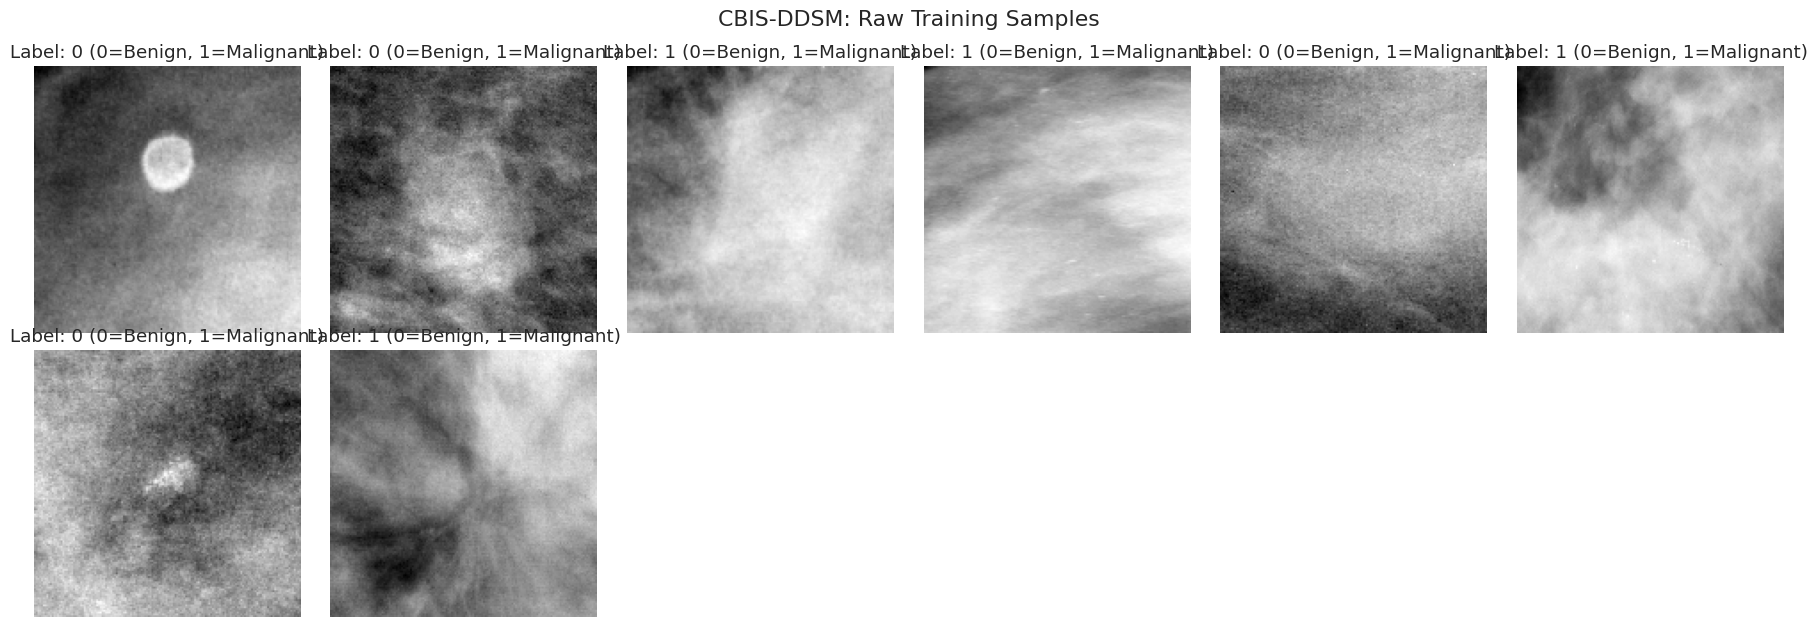

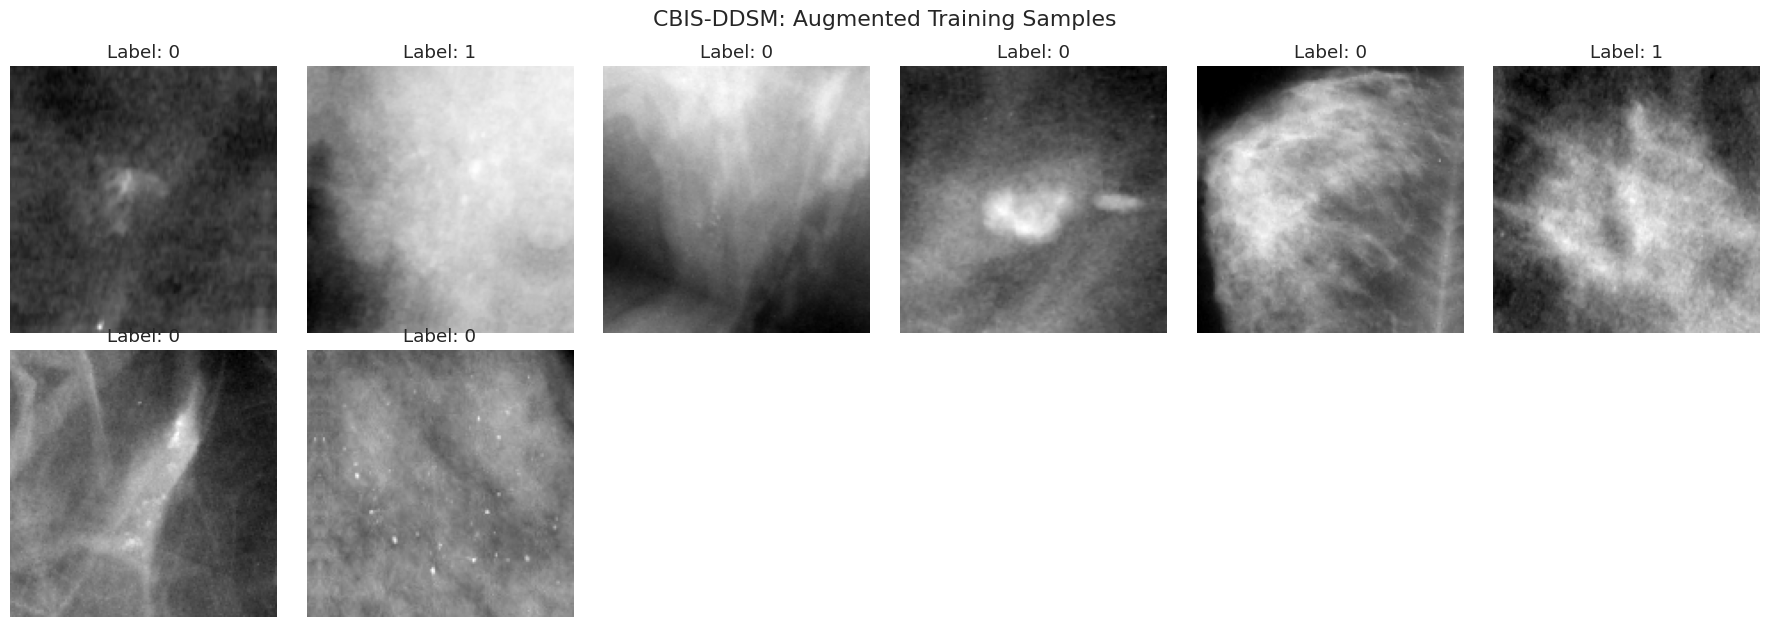

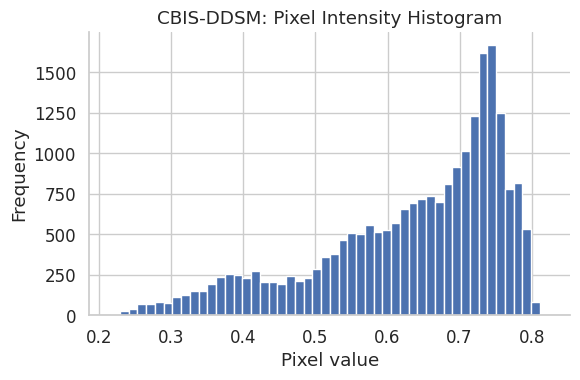

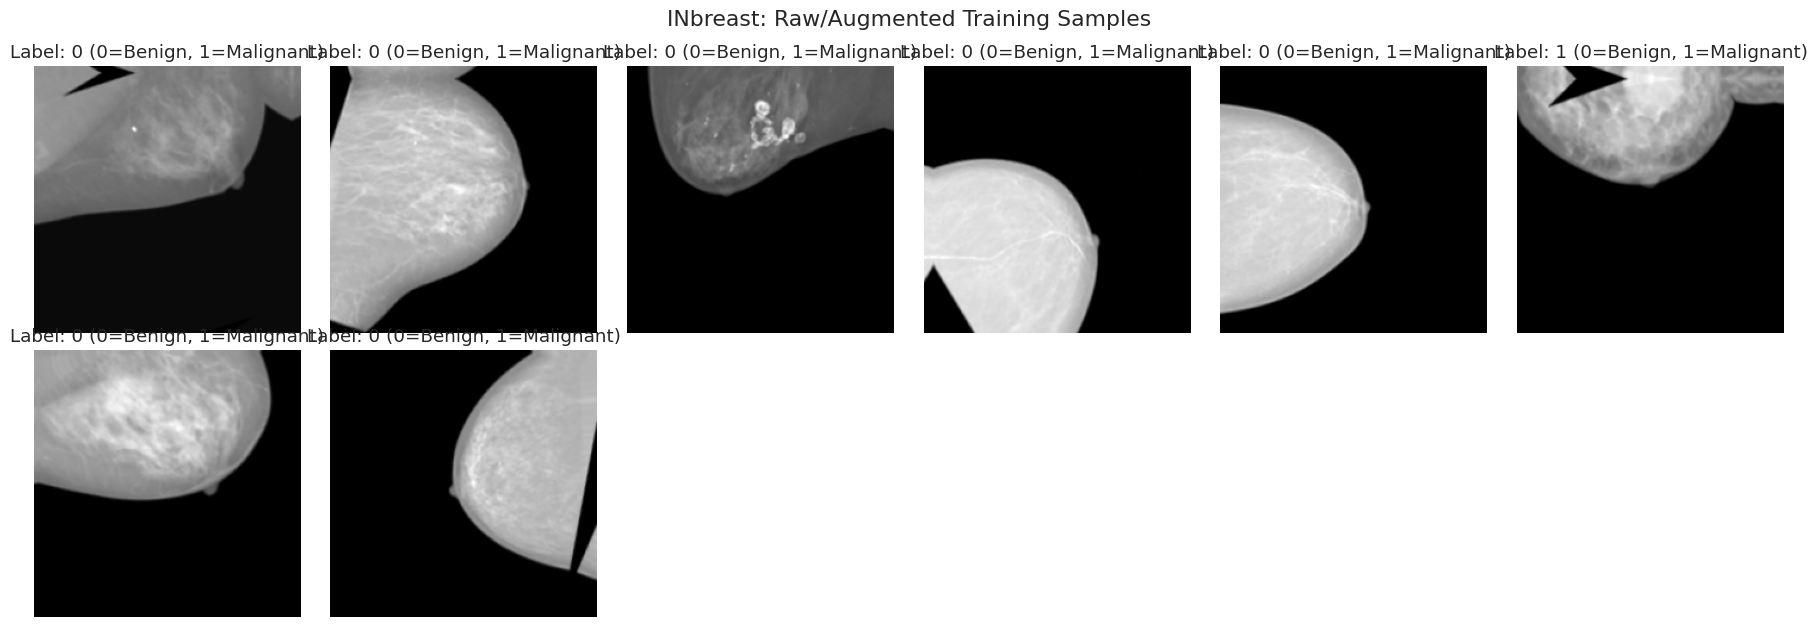

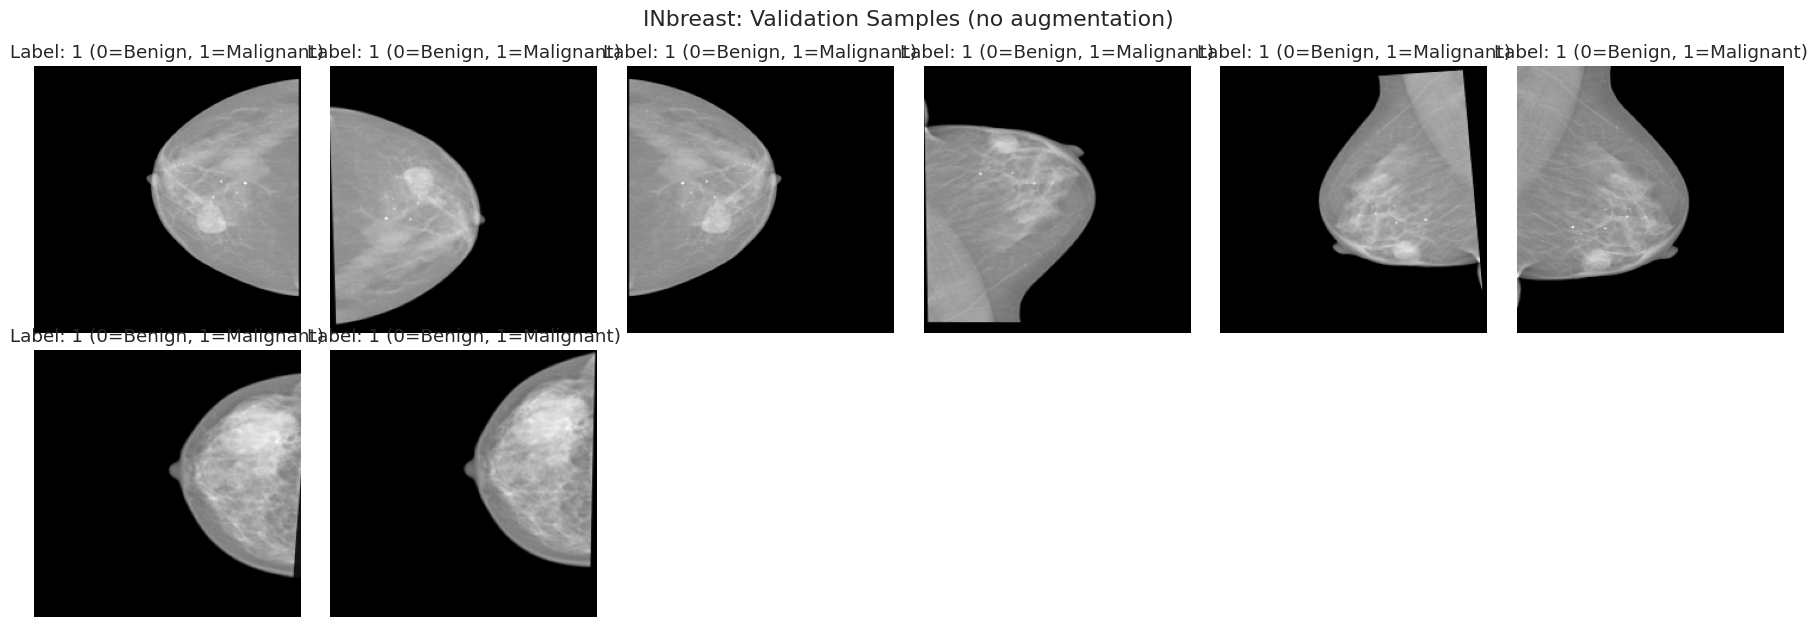

In [79]:
# ================================
# VISUAL INSPECTION OF SAMPLE IMAGES
# ================================
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- A) CBIS-DDSM (arrays) ----------
def plot_cbis_samples(X, y, n=6, title="CBIS-DDSM: Raw Samples"):
    n = min(n, len(X))
    idx = np.random.choice(len(X), n, replace=False)
    cols = min(n, 6)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3.0*cols, 3.2*rows))
    for i, j in enumerate(idx):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[j].squeeze(), cmap="gray")
        plt.title(f"Label: {int(y[j])} (0=Benign, 1=Malignant)")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_cbis_augmented(gen, n=6, title="CBIS-DDSM: Augmented Samples"):
    batch_x, batch_y = next(gen)
    n = min(n, batch_x.shape[0])
    cols = min(n, 6)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3.0*cols, 3.2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(batch_x[i].squeeze(), cmap="gray")
        plt.title(f"Label: {int(batch_y[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_cbis_histogram(X, idx=0, title="CBIS-DDSM: Pixel Intensity Histogram"):
    img = X[idx].squeeze()
    plt.figure(figsize=(6,4))
    plt.hist(img.ravel(), bins=50)
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Call the CBIS visual checks
plot_cbis_samples(X_train, y_train, n=8, title="CBIS-DDSM: Raw Training Samples")
plot_cbis_augmented(cbis_train_gen, n=8, title="CBIS-DDSM: Augmented Training Samples")
plot_cbis_histogram(X_train, idx=0)

# ---------- B) INbreast (tf.data from directory) ----------
def show_inbreast_batch(ds, n=8, title="INbreast: Sample Batch"):
    # Take one batch from the dataset
    for images, labels in ds.take(1):
        imgs = images.numpy()
        labs = labels.numpy().astype(int).squeeze()
        n = min(n, imgs.shape[0])
        cols = min(n, 6)
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(3.0*cols, 3.2*rows))
        for i in range(n):
            plt.subplot(rows, cols, i+1)
            # imgs are (H,W,1) after rescale/aug; squeeze channel for display
            plt.imshow(imgs[i].squeeze(), cmap="gray")
            plt.title(f"Label: {labs[i]} (0=Benign, 1=Malignant)")
            plt.axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
        break

# Only run if INbreast directory/datasets exist
if 'train_ds_inb' in globals():
    show_inbreast_batch(train_ds_inb, n=8, title="INbreast: Raw/Augmented Training Samples")
if 'val_ds_inb' in globals():
    show_inbreast_batch(val_ds_inb, n=8, title="INbreast: Validation Samples (no augmentation)")


## **Dataset Summary and Pixel Value Inspection**

To better understand the input distributions, both CBIS-DDSM and INbreast datasets were summarized and their pixel value ranges inspected. For CBIS-DDSM, the number of training, validation, and test samples was tabulated along with their class distributions, confirming that abnormal-only slices had been correctly extracted and that stratified splitting preserved balance across sets. Pixel value histograms were generated to verify grayscale normalization from 16-bit tensors into the [0,1] float32 range, ensuring stable input scaling for CNN training. For INbreast, the binary mapping of BI-RADS categories into benign versus malignant was validated by examining the number of images per class after DICOM conversion and augmentation. Histograms of intensity values confirmed that z-score normalization followed by rescaling produced consistent grayscale contrast across images. This inspection step was essential to guarantee reproducibility, detect potential biases, and ensure that model performance was not confounded by preprocessing artifacts.


[CBIS - Train]
  X shape: (2140, 150, 150, 1), dtype: float32
  y shape: (2140,), dtype: int64
  Class counts: {0: 1254, 1: 886} (0=benign, 1=malignant)
  Pixel stats -> min: 0.0000  max: 1.0000  mean: 0.5256  std: 0.1572


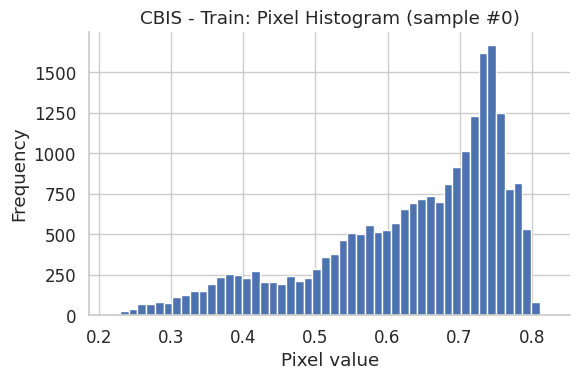


[CBIS - Val]
  X shape: (536, 150, 150, 1), dtype: float32
  y shape: (536,), dtype: int64
  Class counts: {0: 314, 1: 222} (0=benign, 1=malignant)
  Pixel stats -> min: 0.0000  max: 1.0000  mean: 0.5276  std: 0.1557


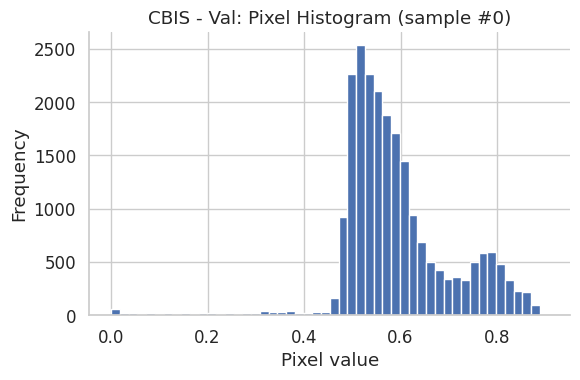


[CBIS - Test]
  X shape: (336, 150, 150, 1), dtype: float32
  y shape: (336,), dtype: int64
  Class counts: {0: 219, 1: 117} (0=benign, 1=malignant)
  Pixel stats -> min: 0.0000  max: 1.0000  mean: 0.5113  std: 0.1731


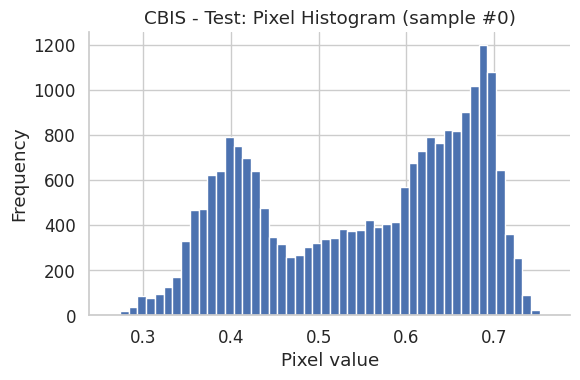


[INbreast - Train (tf.data)]
  Estimated samples (first 10 batches): 320
  Example image shape: (224, 224, 1), dtype: float32
  Class counts (approx): { 0: 242, 1: 78 } (0=benign, 1=malignant)
  Pixel stats (batch-avg) -> min: 0.0000  max: 1.0829  mean: 0.2170  std: 0.3127


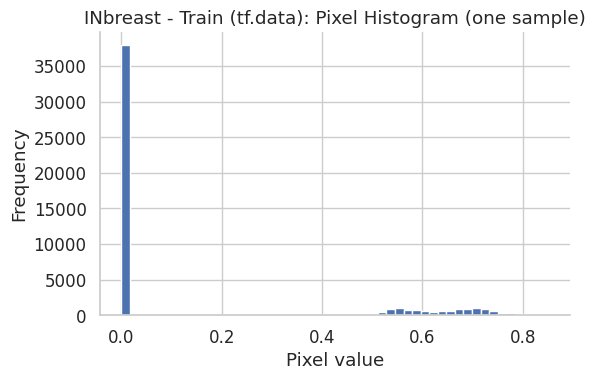


[INbreast - Val (tf.data)]
  Estimated samples (first 10 batches): 246
  Example image shape: (224, 224, 1), dtype: float32
  Class counts (approx): { 0: 0, 1: 246 } (0=benign, 1=malignant)
  Pixel stats (batch-avg) -> min: 0.0000  max: 1.0000  mean: 0.2083  std: 0.3022


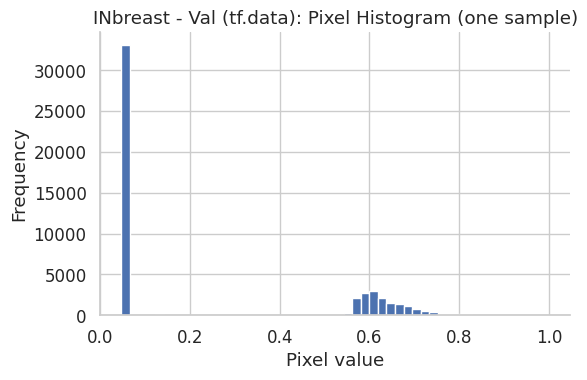

In [80]:
# ================================
# DATASET SUMMARY & PIXEL VALUE INSPECTION
# ================================
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def class_counts(y):
    y = np.array(y).astype(int).ravel()
    cnt = Counter(y)
    return {int(k): int(v) for k,v in sorted(cnt.items())}

def describe_array_split(name, X, y, show_hist=True, hist_idx=0):
    Xs = X.shape
    ys = y.shape
    x_min, x_max = float(X.min()), float(X.max())
    x_mean, x_std = float(X.mean()), float(X.std())
    print(f"\n[{name}]")
    print(f"  X shape: {Xs}, dtype: {X.dtype}")
    print(f"  y shape: {ys}, dtype: {y.dtype}")
    print(f"  Class counts: {class_counts(y)} (0=benign, 1=malignant)")
    print(f"  Pixel stats -> min: {x_min:.4f}  max: {x_max:.4f}  mean: {x_mean:.4f}  std: {x_std:.4f}")
    if show_hist and X.ndim >= 3:
        idx = min(hist_idx, len(X)-1)
        plt.figure(figsize=(6,4))
        plt.hist(X[idx].ravel(), bins=50)
        plt.title(f"{name}: Pixel Histogram (sample #{idx})")
        plt.xlabel("Pixel value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# -------- CBIS-DDSM (arrays already normalized to [0,1]) --------
describe_array_split("CBIS - Train", X_train, y_train, show_hist=True, hist_idx=0)
describe_array_split("CBIS - Val",   X_val,   y_val,   show_hist=True, hist_idx=0)
describe_array_split("CBIS - Test",  test_X,  test_y,  show_hist=True, hist_idx=0)

# -------- INbreast (tf.data) --------
def summarize_tfdata(name, ds, take_batches=10, show_hist=True):
    n_imgs = 0
    labels = []
    mins, maxs, means, stds = [], [], [], []

    # Peek one image for histogram later
    sample_for_hist = None

    for b_idx, (imgs, labs) in enumerate(ds.take(take_batches)):
        arr = imgs.numpy()  # (B,H,W,1)
        labs = labs.numpy().astype(int).ravel()
        # Collect stats (images may already be rescaled to [0,1] in your pipeline)
        mins.append(arr.min())
        maxs.append(arr.max())
        means.append(arr.mean())
        stds.append(arr.std())
        labels.extend(labs.tolist())
        n_imgs += arr.shape[0]
        if sample_for_hist is None:
            sample_for_hist = arr[0]

    if n_imgs == 0:
        print(f"\n[{name}] No data found.")
        return

    print(f"\n[{name}]")
    print(f"  Estimated samples (first {take_batches} batches): {n_imgs}")
    # Shapes may vary; report the shape of the last seen batch element
    print(f"  Example image shape: {sample_for_hist.shape}, dtype: {sample_for_hist.dtype}")
    if labels:
        cnt = Counter(labels)
        print(f"  Class counts (approx): {{ {0}: {cnt.get(0,0)}, {1}: {cnt.get(1,0)} }} (0=benign, 1=malignant)")
    print(f"  Pixel stats (batch-avg) -> "
          f"min: {np.min(mins):.4f}  max: {np.max(maxs):.4f}  "
          f"mean: {np.mean(means):.4f}  std: {np.mean(stds):.4f}")

    if show_hist and sample_for_hist is not None:
        plt.figure(figsize=(6,4))
        plt.hist(sample_for_hist.ravel(), bins=50)
        plt.title(f"{name}: Pixel Histogram (one sample)")
        plt.xlabel("Pixel value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Only run if INbreast datasets exist
if 'train_ds_inb' in globals():
    summarize_tfdata("INbreast - Train (tf.data)", train_ds_inb, take_batches=10, show_hist=True)
if 'val_ds_inb' in globals():
    summarize_tfdata("INbreast - Val (tf.data)",   val_ds_inb,   take_batches=10, show_hist=True)


## **Data Augmentation and Class Balancing**

To address class imbalance and improve model generalization, both datasets underwent tailored augmentation and balancing strategies. For CBIS-DDSM, the minority class was oversampled to match the majority, producing a balanced training set and reducing bias toward malignant or benign labels. Augmentations such as flips, rotations, zooms, and translations were applied, reflecting clinically safe variations while preserving diagnostic features. Validation and test sets remained untouched to ensure fair evaluation. For INbreast, augmentation was integrated directly into the tf.data pipeline using GPU-accelerated Keras layers, enabling real-time transformations during training. Class weights were also computed and applied to further counter residual imbalance, ensuring the model treated benign and malignant findings with equal importance. Together, these steps provided a diverse, balanced input distribution that supports robust training and clinically relevant performance across datasets.

CBIS train class counts: {np.int64(0): np.int64(1254), np.int64(1): np.int64(886)}
CBIS (balanced) class counts: {0: 1254, 1: 1254}
CBIS class_weight (optional): {0: 0.8532695374800638, 1: 1.2076749435665914}
INbreast class_weight (approx): {0: 0.6477732793522267, 1: 2.191780821917808}


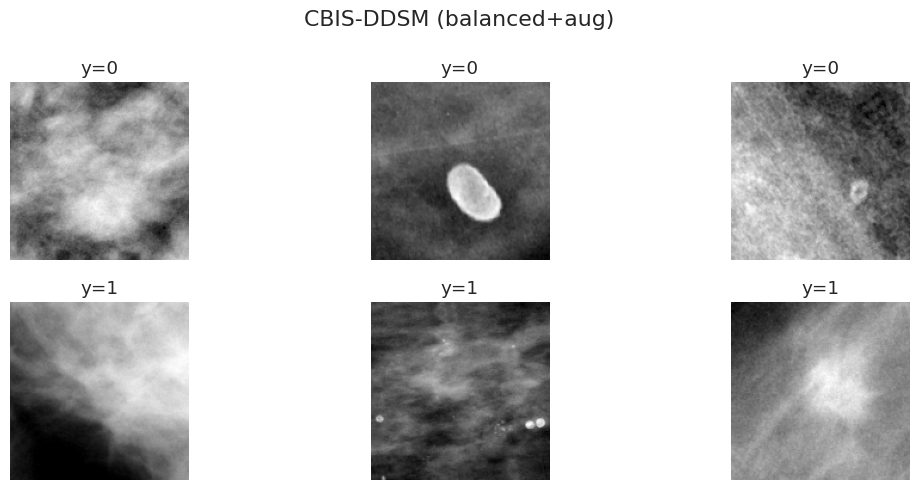

In [81]:
# ================================
# DATA AUGMENTATION & CLASS BALANCING
# ================================
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------------------------
# A) CBIS-DDSM (arrays): oversample + augment
# ---------------------------------

# -- 1) Class counts
unique, counts = np.unique(y_train, return_counts=True)
count_map = dict(zip(unique, counts))
print("CBIS train class counts:", count_map)

# -- 2) Oversample minority to match majority
maj_class = unique[np.argmax(counts)]
maj_count = counts.max()

idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

def oversample_to_n(idxs, n):
    if len(idxs) >= n:
        return np.random.choice(idxs, n, replace=False)
    return np.concatenate([idxs, np.random.choice(idxs, n - len(idxs), replace=True)])

idx_0_bal = oversample_to_n(idx_0, maj_count)
idx_1_bal = oversample_to_n(idx_1, maj_count)

balanced_idx = np.concatenate([idx_0_bal, idx_1_bal])
np.random.shuffle(balanced_idx)

X_train_bal = X_train[balanced_idx]
y_train_bal = y_train[balanced_idx]

print("CBIS (balanced) class counts:",
      {k:int((y_train_bal==k).sum()) for k in [0,1]})

# -- 3) Image augmentation (train) + no-aug (val)
cbis_train_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.05, height_shift_range=0.05,
    shear_range=8, zoom_range=0.15,
    horizontal_flip=True, vertical_flip=True,
    fill_mode="reflect"
)
cbis_val_datagen = ImageDataGenerator()

cbis_train_gen = cbis_train_datagen.flow(
    X_train_bal, y_train_bal, batch_size=32, shuffle=True
)
cbis_val_gen = cbis_val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)

# -- 4) (Optional) class weights instead of oversampling
classes = np.array([0,1])
cw_vals = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cbis_class_weight = {int(c): float(w) for c,w in zip(classes, cw_vals)}
print("CBIS class_weight (optional):", cbis_class_weight)

# ---------------------------------
# B) INbreast (tf.data): augment in-pipeline + class weighting
# ---------------------------------

# If you already built train_ds_inb / val_ds_inb above:
if 'train_ds_inb' in globals() and 'val_ds_inb' in globals():
    # Normalization to [0,1]
    rescale = layers.Rescaling(1./255)

    # GPU-friendly aug (light, clinical-safe)
    inb_aug = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.5),     # ~±180°
        layers.RandomZoom(0.15),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.1),
    ], name="inbreast_aug")

    def map_train(img, label):
        img = rescale(img)
        img = inb_aug(img, training=True)
        return img, label

    def map_val(img, label):
        img = rescale(img)
        return img, label

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds_inb = (train_ds_inb
                    .map(map_train, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .prefetch(AUTOTUNE))
    val_ds_inb = (val_ds_inb
                  .map(map_val, num_parallel_calls=AUTOTUNE)
                  .cache()
                  .prefetch(AUTOTUNE))

    # ---- Class weights for tf.data (computed approx from a few batches)
    sample_labels = []
    for _, yb in train_ds_inb.take(20):  # peek limited batches for speed
        sample_labels.extend(yb.numpy().astype(int).ravel().tolist())
    if len(sample_labels) > 0:
        cw = compute_class_weight("balanced", classes=np.array([0,1]), y=np.array(sample_labels))
        inb_weights = tf.constant([float(cw[0]), float(cw[1])], dtype=tf.float32)
        print("INbreast class_weight (approx):", {0: float(cw[0]), 1: float(cw[1])})

        # attach sample weights to the dataset
        def add_weights(img, label):
            idx = tf.cast(tf.squeeze(label), tf.int32)   # label shape (B,1) or (B,)
            sw = tf.gather(inb_weights, idx)
            return img, label, sw

        train_ds_inb_w = train_ds_inb.map(add_weights, num_parallel_calls=AUTOTUNE)
    else:
        inb_weights = None
        train_ds_inb_w = train_ds_inb
        print("INbreast class_weight skipped (no labels sampled).")
else:
    print("INbreast tf.data not found; skipping INbreast augmentation/weighting setup.")

# ---------------------------------
# C) Quick visual check (optional)
# ---------------------------------
def preview_augmented_batch(gen, n=6, title="Augmented samples"):
    import matplotlib.pyplot as plt
    bx, by = next(gen)
    n = min(n, len(bx))
    plt.figure(figsize=(12, 5))
    for i in range(n):
        plt.subplot(2, (n+1)//2, i+1)
        plt.imshow(bx[i].squeeze(), cmap="gray")
        plt.title(f"y={int(by[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

preview_augmented_batch(cbis_train_gen, n=6, title="CBIS-DDSM (balanced+aug)")
